In [1]:
import os
import glob
import pandas as pd

# =========================
# 0) Build manifest (CSV file list + labels)
# =========================
# ✅ 改成你的 6score 根目錄
root_dir = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score"

# 轉換 中文類別 → 整數 label
label_map = {
    "正常": 0,
    "異常": 1,
    "故障": 2,
}

rows = []

# 走過每一個 turnout 資料夾：P1602N, P1602R, ...
for device_name in os.listdir(root_dir):
    device_path = os.path.join(root_dir, device_name)
    if not os.path.isdir(device_path):
        continue

    # 走過三個子資料夾：正常 / 異常 / 故障
    for class_name in ["正常", "異常", "故障"]:
        class_folder = os.path.join(device_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        csv_paths = glob.glob(os.path.join(class_folder, "*.csv"))
        for path in csv_paths:
            rows.append({
                "file_path": path,
                "device": device_name,
                "class_name": class_name,
                "label_idx": label_map[class_name]
            })

manifest = pd.DataFrame(rows)
print("✅ Manifest built:", manifest.shape)
display(manifest.head())
print("\nClass counts:")
print(manifest["class_name"].value_counts())


✅ Manifest built: (4372, 4)


,file_path,device,class_name,label_idx
0,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
1,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
2,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
3,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0
4,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602N,正常,0



Class counts:
class_name
正常    3222
異常    1028
故障     122
Name: count, dtype: int64


In [2]:
from sklearn.model_selection import train_test_split

# =========================
# 1) Stratified split by (device, class)
# =========================
manifest["strata"] = manifest["device"] + "_" + manifest["class_name"]

print("不同 (device, class) 組合數：", manifest["strata"].nunique())
print(manifest["strata"].value_counts())

# Train 75%, Val 10%, Test 15%
train_df, temp_df = train_test_split(
    manifest,
    test_size=0.25,
    stratify=manifest["strata"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.6,  # temp=25% -> val=10%, test=15%
    stratify=temp_df["strata"],
    random_state=42,
)

print("train/val/test sizes:", len(train_df), len(val_df), len(test_df))


不同 (device, class) 組合數： 16
strata
P1604R_正常    838
P1604N_正常    838
P1603N_正常    526
P1603R_正常    496
P1602N_正常    364
P1603R_異常    324
P1603N_異常    308
P1602R_異常    294
P1602R_正常    160
P1602N_異常    102
P1603N_故障     38
P1603R_故障     28
P1602R_故障     19
P1604N_故障     17
P1602N_故障     12
P1604R_故障      8
Name: count, dtype: int64
train/val/test sizes: 3279 437 656


In [3]:
import os
import time
import json
import platform
import joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# 2) Config: features + model directory
# =========================
CONT_COLS = ["NCurrent", "RCurrent", "WRVT"]
BIN_CAT_COLS = ["NLR", "SRWKR", "SNWKR", "RWKR", "NWKR", "RLR", "FOCR", "NWR", "RWR"]

BATCH_SIZE = 20

# ✅ 這裡改成你 CNN training 時「儲存 best model / scaler / history」的資料夾
MODEL_DIR = "/home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test"

# 你原本 CNN_timing.ipynb 儲存的權重檔名是 best_lstm_model_test.pth（雖然是 CNN）
# 這裡做成「自動找一個 .pth」：如果你改名成 best_cnn_model.pth 也會吃到。
def _auto_find_pth(model_dir: str):
    cands = []
    for fn in os.listdir(model_dir):
        if fn.endswith(".pth"):
            cands.append(fn)
    if not cands:
        return None
    # 偏好包含 best 的檔名
    cands.sort(key=lambda x: (("best" not in x.lower()), x))
    return os.path.join(model_dir, cands[0])

WEIGHTS_PATH = _auto_find_pth(MODEL_DIR)
SCALER_PATH  = os.path.join(MODEL_DIR, "scaler.pkl")
HISTORY_PATH = os.path.join(MODEL_DIR, "history.pkl")

print("MODEL_DIR:", MODEL_DIR)
print("WEIGHTS_PATH:", WEIGHTS_PATH)
print("SCALER_PATH :", SCALER_PATH)
print("HISTORY_PATH:", HISTORY_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# Load scaler
scaler = joblib.load(SCALER_PATH)
print("✅ scaler loaded")

# Load history (optional)
history = None
if os.path.exists(HISTORY_PATH):
    history = joblib.load(HISTORY_PATH)
    print("✅ history loaded")
else:
    print("ℹ️ history.pkl not found, skip curves.")


MODEL_DIR: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test
WEIGHTS_PATH: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test/best_lstm_model_test.pth
SCALER_PATH : /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test/scaler.pkl
HISTORY_PATH: /home/t113ab8043/Desktop/nanten_railway_code/2_ML/loadingmodel/CNN/test/history.pkl
device: cuda
✅ scaler loaded
✅ history loaded


In [4]:
# =========================
# 3) Dataset + collate_fn  (same as training, but scaler is loaded)
# =========================
class EventDataset(Dataset):
    def __init__(self, manifest_df, cont_cols, bin_cat_cols, scaler):
        self.manifest = manifest_df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.bin_cat_cols = bin_cat_cols
        self.scaler = scaler

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        path = row["file_path"]
        label = int(row["label_idx"])

        df = pd.read_csv(path)

        # 缺欄位補 0
        for c in self.cont_cols + self.bin_cat_cols:
            if c not in df.columns:
                df[c] = 0.0

        # 連續特徵標準化
        if self.scaler is not None and not df[self.cont_cols].empty:
            df[self.cont_cols] = self.scaler.transform(df[self.cont_cols])

        feats = []

        # continuous
        for c in self.cont_cols:
            vals = df[c].values.astype(np.float32)
            feats.append(torch.from_numpy(vals).unsqueeze(1))  # (T,1)

        # binary/cat flags
        for c in self.bin_cat_cols:
            vals = (
                df[c]
                .fillna(0)
                .astype(int)
                .clip(0, 1)
                .values
                .astype(np.float32)
            )
            feats.append(torch.from_numpy(vals).unsqueeze(1))  # (T,1)

        features_tensor = torch.cat(feats, dim=1)  # (T, F)

        return {
            "features": features_tensor,
            "length": features_tensor.shape[0],
            "label": torch.tensor(label, dtype=torch.long),
        }

def collate_fn(batch):
    batch = [item for item in batch if item["length"] > 0]
    if not batch:
        return {
            "features": torch.empty(0, 0, 0),
            "lengths": torch.empty(0),
            "labels": torch.empty(0),
        }

    features_list = [item["features"] for item in batch]
    lengths_list  = [item["length"] for item in batch]
    labels_list   = [item["label"] for item in batch]

    padded_features = pad_sequence(
        features_list,
        batch_first=True,
        padding_value=0.0,
    )

    return {
        "features": padded_features,                               # (B, T_max, F)
        "lengths": torch.tensor(lengths_list, dtype=torch.long),   # (B,)
        "labels": torch.stack(labels_list),                        # (B,)
    }

train_dataset = EventDataset(train_df, CONT_COLS, BIN_CAT_COLS, scaler)
val_dataset   = EventDataset(val_df,   CONT_COLS, BIN_CAT_COLS, scaler)
test_dataset  = EventDataset(test_df,  CONT_COLS, BIN_CAT_COLS, scaler)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
)

# 用 test_loader 的第一個 batch 自動抓 feature_dim
temp_batch = next(iter(test_loader))
INPUT_SIZE = temp_batch["features"].shape[2]
NUM_CLASSES = int(manifest["label_idx"].nunique())

print("INPUT_SIZE:", INPUT_SIZE, "NUM_CLASSES:", NUM_CLASSES)


INPUT_SIZE: 12 NUM_CLASSES: 3


In [5]:
# =========================
# 4) CNN1D model definition (must match training)
# =========================
def masked_mean_pool1d(x, lengths):
    if not torch.is_tensor(lengths):
        lengths = torch.tensor(lengths, dtype=torch.long, device=x.device)
    else:
        lengths = lengths.to(x.device)

    B, C, T = x.shape
    t = torch.arange(T, device=x.device).unsqueeze(0)          # (1, T)
    mask = (t < lengths.unsqueeze(1)).unsqueeze(1)             # (B, 1, T)
    x = x * mask
    denom = lengths.clamp(min=1).unsqueeze(1)                  # (B, 1)
    return x.sum(dim=2) / denom                                # (B, C)

def masked_max_pool1d(x, lengths):
    if not torch.is_tensor(lengths):
        lengths = torch.tensor(lengths, dtype=torch.long, device=x.device)
    else:
        lengths = lengths.to(x.device)

    B, C, T = x.shape
    t = torch.arange(T, device=x.device).unsqueeze(0)
    mask = (t < lengths.unsqueeze(1)).unsqueeze(1)
    x = x.masked_fill(~mask, float("-inf"))
    return x.max(dim=2).values

class CNN1DClassifier(nn.Module):
    def __init__(self, in_ch, num_classes, base_ch=64, dropout=0.3, pool="mean"):
        super().__init__()
        assert pool in ["mean", "max"]
        self.pool = pool

        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, base_ch, kernel_size=7, padding=3),
            nn.BatchNorm1d(base_ch),
            nn.ReLU(),

            nn.Conv1d(base_ch, base_ch, kernel_size=5, padding=2),
            nn.BatchNorm1d(base_ch),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Conv1d(base_ch, base_ch * 2, kernel_size=5, padding=2),
            nn.BatchNorm1d(base_ch * 2),
            nn.ReLU(),

            nn.Conv1d(base_ch * 2, base_ch * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(base_ch * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.head = nn.Sequential(
            nn.Linear(base_ch * 2, base_ch * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(base_ch * 2, num_classes),
        )

    def forward(self, x, lengths):
        # x: (B, T, F) -> (B, F, T)
        x = x.permute(0, 2, 1)
        z = self.conv(x)

        if self.pool == "max":
            pooled = masked_max_pool1d(z, lengths)
        else:
            pooled = masked_mean_pool1d(z, lengths)

        logits = self.head(pooled)
        return logits

model = CNN1DClassifier(
    in_ch=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    base_ch=64,
    dropout=0.3,
    pool="mean",
).to(device)

print(model)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


CNN1DClassifier(
  (conv): Sequential(
    (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout(p=0.3, inplace=False)
  )
  (head): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, ou

In [6]:
# =========================
# 5) Load weights
# =========================
assert WEIGHTS_PATH is not None, "❌ No .pth found in MODEL_DIR"

state = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("✅ model weights loaded")


✅ model weights loaded


/tmp/ipykernel_1475814/943231235.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(WEIGHTS_PATH, map_location=device)


Test Loss: 0.0645
Test Acc : 0.9817

Classification Report:
              precision    recall  f1-score   support

           0     0.9857    0.9938    0.9897       484
           1     0.9671    0.9545    0.9608       154
           2     1.0000    0.8889    0.9412        18

    accuracy                         0.9817       656
   macro avg     0.9843    0.9457    0.9639       656
weighted avg     0.9817    0.9817    0.9816       656



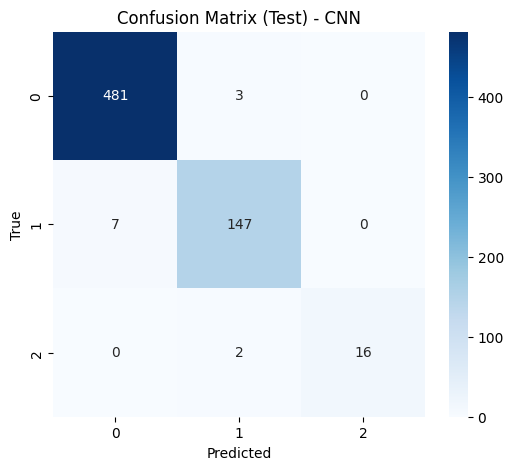

In [7]:
# =========================
# 6) Evaluate on Test set
# =========================
criterion = nn.CrossEntropyLoss()

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_y = []
    all_pred = []

    for batch in loader:
        x = batch["features"].to(device)
        lengths = batch["lengths"]  # keep on CPU ok
        y = batch["labels"].to(device)

        logits = model(x, lengths)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        pred = torch.argmax(logits, dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

        all_y.extend(y.detach().cpu().numpy().tolist())
        all_pred.extend(pred.detach().cpu().numpy().tolist())

    loss_avg = running_loss / max(total, 1)
    acc = correct / max(total, 1)
    return loss_avg, acc, np.array(all_y), np.array(all_pred)

test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Test) - CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# =========================
# 7) Inference timing (ms/sample) + JSON export
# =========================
def _sync_if_cuda(device):
    if device.type == "cuda":
        torch.cuda.synchronize()

@torch.no_grad()
def measure_inference_cnn(model, loader, device, warmup_batches=2):
    model.eval()

    # Warm-up
    for i, batch in enumerate(loader):
        if i >= warmup_batches:
            break
        x = batch["features"].to(device, non_blocking=True)
        lengths = batch["lengths"].to(device, non_blocking=True)
        _ = model(x, lengths)

    _sync_if_cuda(device)

    t0 = time.perf_counter()
    n = 0

    for batch in loader:
        x = batch["features"].to(device, non_blocking=True)
        lengths = batch["lengths"].to(device, non_blocking=True)
        bs = x.shape[0]
        _ = model(x, lengths)
        n += bs

    _sync_if_cuda(device)
    total_s = time.perf_counter() - t0

    ms_per_sample = (total_s / max(n, 1)) * 1000.0
    throughput = (n / max(total_s, 1e-9))

    return {
        "model": "CNN1D",
        "device": str(device),
        "n_samples": int(n),
        "total_s": float(total_s),
        "ms_per_sample": float(ms_per_sample),
        "throughput_samples_per_s": float(throughput),
        "torch_version": torch.__version__,
        "platform": platform.platform(),
    }

timing = measure_inference_cnn(model, test_loader, device, warmup_batches=2)
print(timing)

out_path = os.path.join(MODEL_DIR, "efficiency_cnn_inference.json")
with open(out_path, "w") as f:
    json.dump(timing, f, indent=2)
print("✅ saved:", out_path)


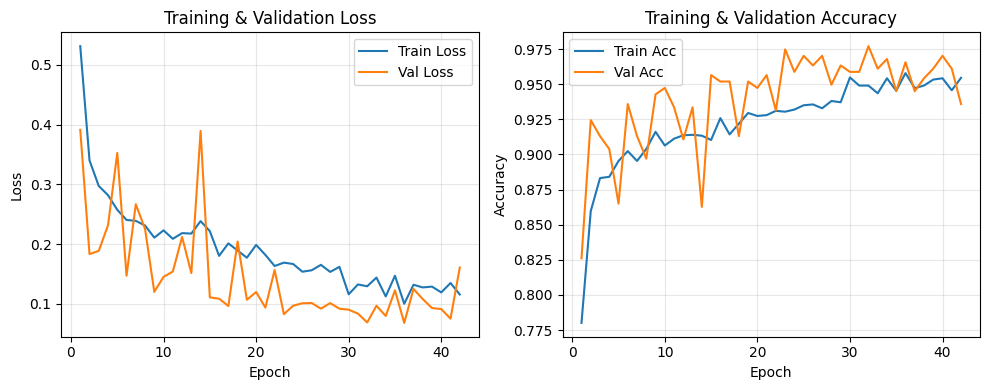

In [8]:
# =========================
# 8) Plot training curves (optional)
# =========================
if history is not None:
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
